必要となるモジュールのインポート

In [17]:
import pandas as pd
import numba 
import numpy as np
import os
import errno

# coding: utf-8
import configparser

import sys
from datetime import datetime as dt

import matplotlib as mpl
import matplotlib.pyplot as plt



pickelデータを読み込む

In [18]:
# df = pd.read_pickle(r'E:/historical_data/XAUUSD/pkl/XAUUSD_GMT+0_NO-DST_20200101-20240106.pkl')

# 取引履歴のdfを用意

In [19]:
cols = [
       '日時',
       '売値',
       '買値',
       '新規買',
       '新規売',
       '追加買',
       '追加売',
       '決済買',# 注文タイプ
       '決済売',
       '実現損益', # 実現損益
       'エントリー買ロット数', # 新しく持ったbuyポジションのlot数
       '買ポジション数', # buyポジション数
       '合計買ロット数', # buyポジションのlot数合計
       '買平均価格', # buyポジションの平均価格
       '買含み損益', # buyポジションの含み損益
       'エントリー売ロット数', # 新しく持ったsellポジションのlot数
       '売ポジション数', # sellポジション数
       '合計売ロット数', # sellポジションのlot数合計
       '売平均価格', # sellポジションの平均価格
       '売含み損益', # sellポジションの含み損益
       '合計損益', # これまでの合計損益
       'buy整理用',
       'sell整理用'
       ]
df_orders = pd.DataFrame(index=[], columns=cols)

Input設定

In [20]:
# iniファイルの読み込み
parameter_ini = configparser.ConfigParser()
parameter_ini_path = r'D:/ドキュメント/FX/EA/制作/Python/000_測定用（バックテストのみ）/100profit.ini'

# 指定したiniファイルが存在しない場合、エラー発生
if not os.path.exists(parameter_ini_path):
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), parameter_ini_path)
parameter_ini.read(parameter_ini_path,encoding="utf-8")

#パラメータ変数の設定
symbol    = parameter_ini.get('DEFAULT', 'symbol')
first_lot = parameter_ini.getfloat('DEFAULT', 'first_lot')
nanpin_range = parameter_ini.getint('DEFAULT', 'nanpin_range')
position_limit = parameter_ini.getint('DEFAULT', 'position_limit')
nanpin_mode = parameter_ini.get('DEFAULT', 'nanpin_mode')
martin_lot = parameter_ini.getfloat('DEFAULT', 'martin_lot')
addition_lot = parameter_ini.getfloat('DEFAULT', 'addition_lot')
profit_mode = parameter_ini.get('DEFAULT', 'profit_mode')
profit_pips = parameter_ini.getint('DEFAULT', 'profit_pips')
magic_number = parameter_ini.getint('DEFAULT', 'magic_number')
slippage = parameter_ini.getint('DEFAULT', 'slippage')
spread_limit = parameter_ini.getint('DEFAULT', 'spread_limit')
open_time = parameter_ini.getint('DEFAULT', 'open_time')
close_time = parameter_ini.getint('DEFAULT', 'close_time')

pip_value = parameter_ini.getint('DEFAULT', 'pip_value')
point = parameter_ini.getfloat('DEFAULT', 'point')

取引時間の設定

In [21]:
start_day = "20220701"
end_day = "20221231"
date_index = pd.date_range(start=start_day, end=end_day, freq="D")
AC_date_list = date_index.to_series().dt.strftime("%Y-%m-%d")
AC_date_list0 = AC_date_list[:5]
AC_date_list


2022-07-01    2022-07-01
2022-07-02    2022-07-02
2022-07-03    2022-07-03
2022-07-04    2022-07-04
2022-07-05    2022-07-05
                 ...    
2022-12-27    2022-12-27
2022-12-28    2022-12-28
2022-12-29    2022-12-29
2022-12-30    2022-12-30
2022-12-31    2022-12-31
Freq: D, Length: 184, dtype: object

ループ処理

In [22]:
@numba.njit
def calc_orders(
        first_lot,
        current_buy_lot,
        current_buy_price,
        current_sell_lot,
        current_sell_price,
        buy_position,
        total_buy_lot,
        averageOpenPrice_buy,
        buy_profit,
        sell_position,
        total_sell_lot,
        averageOpenPrice_sell,
        sell_profit,
        total_profit,
        point,
        spread_limit,
        tick_len,
        tick_bid,
        tick_ask,
        buy_number,
        sell_number,
        ):

    orders_time = tick_bid.copy()
    orders_time[:] = np.nan

    orders_ask = tick_bid.copy()
    orders_ask[:] = np.nan

    orders_bid = tick_bid.copy()
    orders_bid[:] = np.nan

    orders_new_buy = tick_bid.copy()
    orders_new_buy[:] = np.nan

    orders_new_sell = tick_bid.copy()
    orders_new_sell[:] = np.nan
    
    orders_nanpin_buy = tick_bid.copy()
    orders_nanpin_buy[:] = np.nan

    orders_nanpin_sell = tick_bid.copy()
    orders_nanpin_sell[:] = np.nan

    orders_close_buy = tick_bid.copy()
    orders_close_buy[:] = np.nan

    orders_close_sell = tick_bid.copy()
    orders_close_sell[:] = np.nan

    orders_profit = tick_bid.copy()
    orders_profit[:] = np.nan

    orders_buy_lot = tick_bid.copy()
    orders_buy_lot[:] = np.nan

    orders_buy_position = tick_bid.copy()
    orders_buy_position[:] = np.nan

    orders_total_buy_lot = tick_bid.copy()
    orders_total_buy_lot[:] = np.nan

    orders_buy_price = tick_bid.copy()
    orders_buy_price[:] = np.nan

    orders_buy_profit = tick_bid.copy()
    orders_buy_profit[:] = np.nan

    orders_sell_lot = tick_bid.copy()
    orders_sell_lot[:] = np.nan

    orders_sell_position = tick_bid.copy()
    orders_sell_position[:] = np.nan
    
    orders_total_sell_lot = tick_bid.copy()
    orders_total_sell_lot[:] = np.nan

    orders_sell_price = tick_bid.copy()
    orders_sell_price[:] = np.nan

    orders_sell_profit = tick_bid.copy()
    orders_sell_profit[:] = np.nan

    orders_total_profit = tick_bid.copy()
    orders_total_profit[:] = np.nan

    orders_buy_number = tick_bid.copy()
    orders_buy_number[:] = np.nan

    orders_sell_number = tick_bid.copy()
    orders_sell_number[:] = np.nan
 
    if tick_len > 0:    
        for i in range(tick_len): # 全てのポジションを確認（回数をtick数に設定）
            
            bid = tick_bid[i] # 売値の取得（バックテスト用）
            ask = tick_ask[i] # 買値の取得（バックテスト用）
            spread = ask - bid # スプレッドの算出（バックテスト用）
     
            ###entry_flgロジック
            if spread < spread_limit * point:
                entry_flg = 1
            else:
                entry_flg = 0
           
            ######ポジションの含み益の計算（バックテスト用）##########
            if total_buy_lot == 0:
                buy_profit = 0
            else :
                buy_profit = round((bid - averageOpenPrice_buy) * total_buy_lot * pip_value / 0.01, 0)
            if total_sell_lot == 0:
                sell_profit = 0
            else:
                sell_profit = round(-(ask - averageOpenPrice_sell) * total_sell_lot * pip_value / 0.01, 0)
            
            ##ordersに出力
            orders_bid[i] = bid
            orders_ask[i] = ask
            orders_buy_position[i] = buy_position
            orders_total_buy_lot[i] = total_buy_lot
            orders_buy_price[i] = averageOpenPrice_buy
            orders_buy_profit[i] = buy_profit
            orders_sell_position[i] = sell_position
            orders_total_sell_lot[i] = total_sell_lot
            orders_sell_price[i] = averageOpenPrice_sell
            orders_sell_profit[i] = sell_profit
            orders_total_profit[i] = total_profit


            #####

            ######################################################

            ####初回エントリー(buy)#################################
        
            if buy_position == 0 and entry_flg == 1:  # buyポジションがない場合
                buy_position = 1 # buyポジションのカウント
                current_buy_lot = first_lot # 最新のbuyポジションのlot数を取得
                total_buy_lot = first_lot # buyポジションの合計lot数を取得
                current_buy_price = ask # 最新のbuyポジションの取得価格を取得
                averageOpenPrice_buy = ask # buyポジションの平均取得単価を計算
                buy_number += 1
                
                ##ordersに出力
                orders_new_buy[i] = 1
                orders_buy_position[i] = buy_position
                orders_profit[i] = 0
                orders_buy_lot[i] = current_buy_lot
                orders_total_buy_lot[i] = total_buy_lot
                orders_buy_price[i] = current_buy_price
                orders_buy_number[i] = buy_number

            ######################################################

            ####初回エントリー(sell)#################################
            
            if (sell_position == 0 and entry_flg == 1):  # sellポジションがない場合
                sell_position = 1 # sellポジションのカウント
                current_sell_lot = first_lot # 最新のsellポジションのlot数を取得
                total_sell_lot = first_lot # sellポジションの合計lot数を取得
                current_sell_price = bid # 最新のsellポジションの取得価格を取得
                averageOpenPrice_sell = bid # sellポジションの平均取得単価を計算
                sell_number += 1

                ##ordersに出力
                orders_new_sell[i] = 1
                orders_sell_position[i] = sell_position
                orders_profit[i] = 0
                orders_sell_lot[i] = current_sell_lot
                orders_total_sell_lot[i] = total_sell_lot
                orders_sell_price[i] = current_sell_price
                orders_sell_number[i] = sell_number

    
            ################################################################

            #### 追加buyエントリー###########################################
            if ( buy_position > 0 and
                buy_position < position_limit and
                entry_flg == 1 and
                ask < current_buy_price - nanpin_range * point
                ):
                buy_position += 1 # buyポジションを追加
                x = total_buy_lot * averageOpenPrice_buy # 平均価格算出用
                if nanpin_mode == 'martin':
                    current_buy_lot = round(current_buy_lot * martin_lot, 2) # 最新のbuyポジションのlot数
                elif nanpin_mode == 'addition' :
                    current_buy_lot = current_buy_lot + addition_lot # 最新のbuyポジションのlot数
                total_buy_lot += current_buy_lot # buyポジションのlot数合計
                current_buy_price = ask # 最新のbuyポジション価格
                y = current_buy_lot * current_buy_price # 平均価格算出用
                averageOpenPrice_buy = round(( x + y ) / total_buy_lot, 2) # buyポジションの平均価格

                ##ordersに出力
                orders_nanpin_buy[i] = 1
                orders_buy_position[i] = buy_position
                orders_profit[i] = 0
                orders_buy_lot[i] = current_buy_lot
                orders_total_buy_lot[i] = total_buy_lot
                orders_buy_price[i] = averageOpenPrice_buy
                orders_buy_number[i] = buy_number


            ##################################################################
            
            
            #### 追加sellエントリー###########################################
            
            if (
                sell_position > 0 and
                sell_position < position_limit and
                entry_flg == 1 and
                bid > current_sell_price + nanpin_range * point
                ):
                sell_position += 1 # sellポジションを追加
                x = total_sell_lot * averageOpenPrice_sell # 平均価格算出用
                if nanpin_mode == 'martin':
                    current_sell_lot = round(current_sell_lot * martin_lot, 2) # 最新のsellポジションのlot数
                elif nanpin_mode == 'addition' :
                    current_sell_lot = current_sell_lot + addition_lot # 最新のsellポジションのlot数
                total_sell_lot += current_sell_lot # buyポジションのlot数合計
                current_sell_price = bid # 最新のbuyポジション価格
                y = current_sell_lot * current_sell_price # 平均価格算出用
                averageOpenPrice_sell = round(( x + y ) / total_sell_lot, 2) # buyポジションの平均価格

                ##ordersに出力
                orders_nanpin_sell[i] = 1
                orders_sell_position[i] = sell_position
                orders_profit[i] = 0
                orders_sell_lot[i] = current_sell_lot
                orders_total_sell_lot[i] = total_sell_lot
                orders_sell_price[i] = averageOpenPrice_sell
                orders_sell_number[i] = sell_number


            ##################################################################
            
            ###buy_closeロジック###############################################

            if profit_mode == 'average' :
                if bid > averageOpenPrice_buy + profit_pips * 0.01:
                    buy_close_flg = 1
                else:
                    buy_close_flg = 0
            else:
                if bid > current_buy_price + profit_pips * 0.01 :
                    buy_close_flg = 1
                else:
                    buy_close_flg = 0
        
            #### buyクローズ##################################################
            
            if buy_position > 0 and buy_close_flg == 1:

                ##ordersに出力
                orders_close_buy[i] = 1

                orders_buy_position[i] = 0

                orders_total_buy_lot[i] = 0
                orders_profit[i] = buy_profit
                orders_buy_profit[i] = 0
                total_profit += buy_profit
                orders_total_profit[i] = total_profit
                orders_buy_number[i] = buy_number

                #####

                buy_position = 0 # buyポジション数の初期化
                buy_profit = 0 # buy_profitの初期化
                current_buy_lot = 0 # 最新のbuyポジションのlot数の初期化
                total_buy_lot = 0 # buyポジションのlot数合計の初期化
                current_buy_price = 0 # 最新のbuyポジション価格の初期化
                averageOpenPrice_buy = 0 # buyポジションの平均価格の初期化
               

            ##################################################################
            
            ###sell_closeロジック#############################################
            if profit_mode == 'average' :
                if ask < averageOpenPrice_sell - profit_pips * 0.01 :
                    sell_close_flg = 1
                else:
                    sell_close_flg = 0
            else:
                if ask < current_sell_price - profit_pips * 0.01 :
                    sell_close_flg = 1
                else:
                    sell_close_flg = 0
            
            #### sellクローズ#################################################
            
            if sell_position > 0 and sell_close_flg == 1 :
            
                ##ordersに出力
                orders_close_sell[i] = 1

                orders_sell_position[i] = 0
                orders_total_sell_lot[i] = 0
                orders_profit[i] = sell_profit
                orders_sell_profit[i] = 0
                total_profit += sell_profit
                orders_total_profit[i] = total_profit
                orders_sell_number[i] = sell_number

                #####

                sell_position = 0 # sellポジション数の初期化
                sell_profit = 0 # sell_profitの初期化
                current_sell_lot = 0 # 最新のsellポジションのlot数の初期化
                total_sell_lot = 0 # sellポジションのlot数合計の初期化
                current_sell_price = 0 # 最新のsellポジション価格の初期化
                averageOpenPrice_sell = 0 # sellポジションの平均価格の初期化

            ##################################################################
             
    # 返り値を設定
    return (orders_bid,
            orders_ask,
            orders_new_buy,
            orders_new_sell,
            orders_nanpin_buy,
            orders_nanpin_sell,
            orders_close_buy,
            orders_close_sell,
            orders_profit,
            orders_buy_lot,
            orders_buy_position,
            orders_total_buy_lot,
            orders_buy_price,
            orders_buy_profit,
            orders_sell_lot,
            orders_sell_position,
            orders_total_sell_lot,
            orders_sell_price,
            orders_sell_profit,
            orders_total_profit,
            orders_buy_number,
            orders_sell_number,
            current_buy_lot,
            current_buy_price,
            current_sell_lot,
            current_sell_price,
            buy_position,
            buy_profit,
            sell_position,
            sell_profit,
            total_profit,
            total_buy_lot,
            total_sell_lot,           
            averageOpenPrice_buy,
            averageOpenPrice_sell,
            buy_number,
            sell_number,)

In [23]:
current_buy_lot=0.00
current_buy_price=0.00
current_sell_lot=0.00
current_sell_price=0.00
buy_position=0
total_buy_lot=0.00
buy_profit=0
sell_position=0
total_sell_lot=0.00
averageOpenPrice_buy=0.00
averageOpenPrice_sell=0.00
sell_profit=0
total_profit=0
buy_number = 0
sell_number = 0


In [24]:
confirm_path = 'D:/ドキュメント/FX/EA/分析/自作EA/000_測定用（バックテストのみ）/pkl'
df = pd.read_pickle(r'E:/historical_data/XAUUSD/pkl/XAUUSD_GMT+0_NO-DST_20220101-20240106.pkl')

for AC_date in AC_date_list:

    YYYYMM = AC_date[:4] + AC_date[5:7]
    YYYY_MM = AC_date[0:7]

    df_date = df[AC_date + ' 00:00:00' : AC_date + ' 23:59:59' ]
    df_tick = df_date.reset_index()

    if(len(df_tick)>0):

        df_date = pd.DataFrame(index=[], columns=cols)

        (
        df_date['売値'], 
        df_date['買値'], 
        df_date['新規買'], 
        df_date['新規売'],
        df_date['追加買'], 
        df_date['追加売'], 
        df_date['決済買'], 
        df_date['決済売'], 
        df_date['実現損益'],
        df_date['エントリー買ロット数'],
        df_date['買ポジション数'], 
        df_date['合計買ロット数'],
        df_date['買平均価格'], 
        df_date['買含み損益'],
        df_date['エントリー売ロット数'],
        df_date['売ポジション数'], 
        df_date['合計売ロット数'], 
        df_date['売平均価格'], 
        df_date['売含み損益'],
        df_date['合計損益'],
        df_date['buy整理用'],
        df_date['sell整理用'],
        current_buy_lot, 
        current_buy_price,
        current_sell_lot,
        current_sell_price,
        buy_position, 
        buy_profit,
        sell_position,
        sell_profit,
        total_profit,
        total_buy_lot,
        total_sell_lot, 
        averageOpenPrice_buy,
        averageOpenPrice_sell,
        buy_number,
        sell_number,
        )= calc_orders(
            first_lot = first_lot,
            current_buy_lot = current_buy_lot,
            current_buy_price = current_buy_price,
            current_sell_lot = current_sell_lot,
            current_sell_price = current_sell_price,
            buy_position = buy_position,
            total_buy_lot = total_buy_lot,
            averageOpenPrice_buy = averageOpenPrice_buy,
            buy_profit = buy_profit,
            sell_position = sell_position,
            total_sell_lot = total_sell_lot,
            averageOpenPrice_sell = averageOpenPrice_sell,
            sell_profit = sell_profit,
            total_profit = total_profit,
            point = point,
            spread_limit = spread_limit,
            tick_len = len(df_tick),
            tick_bid = df_tick['bid'].values,
            tick_ask = df_tick['ask'].values,
            buy_number = buy_number,
            sell_number = sell_number
            )
      
        df_date['日時'] = df_tick['time']
        df_date['スプレッド'] = df_tick['spread']
        df_date['ピップ値'] = pip_value

        #df = df.dropna( )
        df_date.to_pickle(confirm_path + '/df_orders_'+ AC_date + '.pkl')
print(df)

                              bid       ask  spread
time                                               
2022-01-02 23:00:00.245  1828.604  1829.656   1.052
2022-01-02 23:00:00.295  1828.544  1829.866   1.322
2022-01-02 23:00:00.396  1829.294  1830.156   0.862
2022-01-02 23:00:00.447  1829.324  1830.796   1.472
2022-01-02 23:00:00.548  1829.454  1830.936   1.482
...                           ...       ...     ...
2024-01-05 21:59:58.104  2045.405  2045.792   0.387
2024-01-05 21:59:58.256  2045.398  2045.775   0.377
2024-01-05 21:59:58.458  2045.398  2045.802   0.404
2024-01-05 21:59:58.911  2045.408  2045.802   0.394
2024-01-05 21:59:59.062  2045.355  2045.975   0.620

[90669109 rows x 3 columns]


In [25]:
df = pd.read_csv(r'D:\ドキュメント\FX\EA\分析\自作EA\000_測定用（バックテストのみ）\pkl\df_orders_2022-01.csv')

In [26]:
for AC_date in AC_date_list0:
    file_exists = os.path.exists(confirm_path + '/df_orders_'+AC_date+'.pkl')
    if file_exists:
        df = pd.read_pickle(confirm_path + '/df_orders_' + AC_date+'.pkl')
        df_orders = df.iloc[0:0]

for AC_date in AC_date_list:
    file_exists = os.path.exists(confirm_path + '/df_orders_'+AC_date+'.pkl')
    if file_exists:
        df = pd.read_pickle(confirm_path + '/df_orders_'+AC_date+'.pkl')
        df_orders = pd.concat([df_orders,df])

# df_orders.to_pickle(confirm_path + '/df_orders_'+YYYY_MM+'.pkl')
df_orders.to_csv(confirm_path + '/df_orders_'+YYYY_MM+'.csv')

df_orders

MemoryError: Unable to allocate 1.69 GiB for an array with shape (9, 25171905) and data type float64

MemoryError: Unable to allocate 192. MiB for an array with shape (25171905, 1) and data type float64

グループ分けのためのカウントを取得

In [ ]:
def GetCounts(df):
    i = 0
    for index, item in df.iterrows():
        if  item['OrderLots'] == 0.01 :
            i += 1
        df.loc[index, 'Count'] = i     
    return df

　所持Pipsを計算する

In [ ]:
def CalcHavePips(df) :
    for index, item in df.iterrows():
        nowCount = item['Count']
        nowMaxLots = df.loc[df.Count == nowCount].OrderLots.max()
        df.loc[index, 'MinHavePips'] = (nowMaxLots - item.loc['OrderLots']) * 1000
        df.loc[index, 'MaxHavePips'] = (nowMaxLots - item.loc['OrderLots']) * 1000 + 10
    return df

サマリーを表示

In [ ]:
df_open_buy = df_orders.query('新規買 == 1.0 | 追加買 == 1.0')
df_open_sell = df_orders.query('新規売 == 1.0 | 追加売 == 1.0')
df_close_buy = df_orders.query('決済買 == 1.0')
df_close_sell = df_orders.query('決済売 == 1.0')

df_buy_merged = pd.merge(df_open_buy,df_close_buy, on='buy整理用')
df_sell_merged = pd.merge(df_open_sell,df_close_sell, on='sell整理用')

df_buy_merged['損益'] = round((df_buy_merged['売値_y'] - df_buy_merged['買値_x']) * df_buy_merged['エントリー買ロット数_x'] * df_buy_merged['ピップ値_x'] / 0.01,0)
df_buy_merged['OrderType'] = 'BUY'
df_buy_merged = df_buy_merged.loc[:,['OrderType','エントリー買ロット数_x','買値_x','日時_x','売値_y','日時_y','損益']].sort_values('日時_x')
df_sell_merged['損益'] = round((df_sell_merged['売値_x'] - df_sell_merged['買値_y']) * df_sell_merged['エントリー売ロット数_x'] * df_sell_merged['ピップ値_x'] / 0.01,0)
df_sell_merged['OrderType'] = 'SELL'
df_sell_merged = df_sell_merged.loc[:,['OrderType','エントリー売ロット数_x','売値_x','日時_x','買値_y','日時_y','損益']].sort_values('日時_x')

df_buy_merged = df_buy_merged.rename(columns={'エントリー買ロット数_x':'OrderLots','買値_x':'OrderOpenPrice','日時_x':'OrderOpenTime','売値_y':'OrderClosePrice','日時_y':'OrderCloseTime','損益':'Profit'})

df_sell_merged = df_sell_merged.rename(columns={'エントリー売ロット数_x':'OrderLots','売値_x':'OrderOpenPrice','日時_x':'OrderOpenTime','買値_y':'OrderClosePrice','日時_y':'OrderCloseTime','損益':'Profit'})

GetCounts(df_buy_merged)
GetCounts(df_sell_merged)
CalcHavePips(df_buy_merged)    
CalcHavePips(df_sell_merged)    


df_data = pd.concat([df_buy_merged,df_sell_merged], ignore_index=True)
df_data = df_data.sort_values('OrderOpenTime')

df_data['EntryTime'] = pd.to_datetime(df_data.OrderOpenTime)
df_data['CloseTime'] = pd.to_datetime(df_data.OrderCloseTime)

df_data['HaveTime'] = df_data['CloseTime'] - df_data['EntryTime']


df_data.to_csv(r'D:\ドキュメント\FX\EA\分析\自作EA\000_測定用（バックテストのみ）\result\order_record_' start_day + '-' + end_day + '.csv')
df_data.reset_index(drop=True)


,OrderType,OrderLots,OrderOpenPrice,OrderOpenTime,OrderClosePrice,OrderCloseTime,Profit,Count,MinHavePips,MaxHavePips,EntryTime,CloseTime,HaveTime
0,BUY,0.01,1829.656,2022-01-02 23:00:00.245,1830.704,2022-01-02 23:03:23.531,157.0,1.0,0.0,10.0,2022-01-02 23:00:00.245,2022-01-02 23:03:23.531,0 days 00:03:23.286000
1,SELL,0.01,1828.604,2022-01-02 23:00:00.245,1829.652,2022-01-02 23:23:00.303,-157.0,1.0,20.0,30.0,2022-01-02 23:00:00.245,2022-01-02 23:23:00.303,0 days 00:23:00.058000
2,SELL,0.02,1829.614,2022-01-02 23:00:54.201,1829.652,2022-01-02 23:23:00.303,-11.0,1.0,10.0,20.0,2022-01-02 23:00:54.201,2022-01-02 23:23:00.303,0 days 00:22:06.102000
3,SELL,0.03,1830.654,2022-01-02 23:03:11.110,1829.652,2022-01-02 23:23:00.303,451.0,1.0,0.0,10.0,2022-01-02 23:03:11.110,2022-01-02 23:23:00.303,0 days 00:19:49.193000
4,BUY,0.01,1831.236,2022-01-02 23:03:24.901,1831.458,2022-01-02 23:09:17.042,33.0,2.0,10.0,20.0,2022-01-02 23:03:24.901,2022-01-02 23:09:17.042,0 days 00:05:52.141000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58044,SELL,0.01,1804.488,2022-06-30 22:12:58.618,1805.562,2022-06-30 23:01:57.828,-161.0,12392.0,20.0,30.0,2022-06-30 22:12:58.618,2022-06-30 23:01:57.828,0 days 00:48:59.210000
58045,SELL,0.02,1805.538,2022-06-30 22:13:17.521,1805.562,2022-06-30 23:01:57.828,-7.0,12392.0,10.0,20.0,2022-06-30 22:13:17.521,2022-06-30 23:01:57.828,0 days 00:48:40.307000
58046,BUY,0.01,1806.692,2022-06-30 22:27:27.060,1806.688,2022-06-30 23:50:45.190,-1.0,12393.0,10.0,20.0,2022-06-30 22:27:27.060,2022-06-30 23:50:45.190,0 days 01:23:18.130000
58047,SELL,0.03,1806.578,2022-06-30 22:31:00.259,1805.562,2022-06-30 23:01:57.828,457.0,12392.0,0.0,10.0,2022-06-30 22:31:00.259,2022-06-30 23:01:57.828,0 days 00:30:57.569000


<Axes: xlabel='日時'>

d:\Programming\python\venv\main\FX\.venv\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  func(*args, **kwargs)
d:\Programming\python\venv\main\FX\.venv\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from current font.
  func(*args, **kwargs)
d:\Programming\python\venv\main\FX\.venv\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Programming\python\venv\main\FX\.venv\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


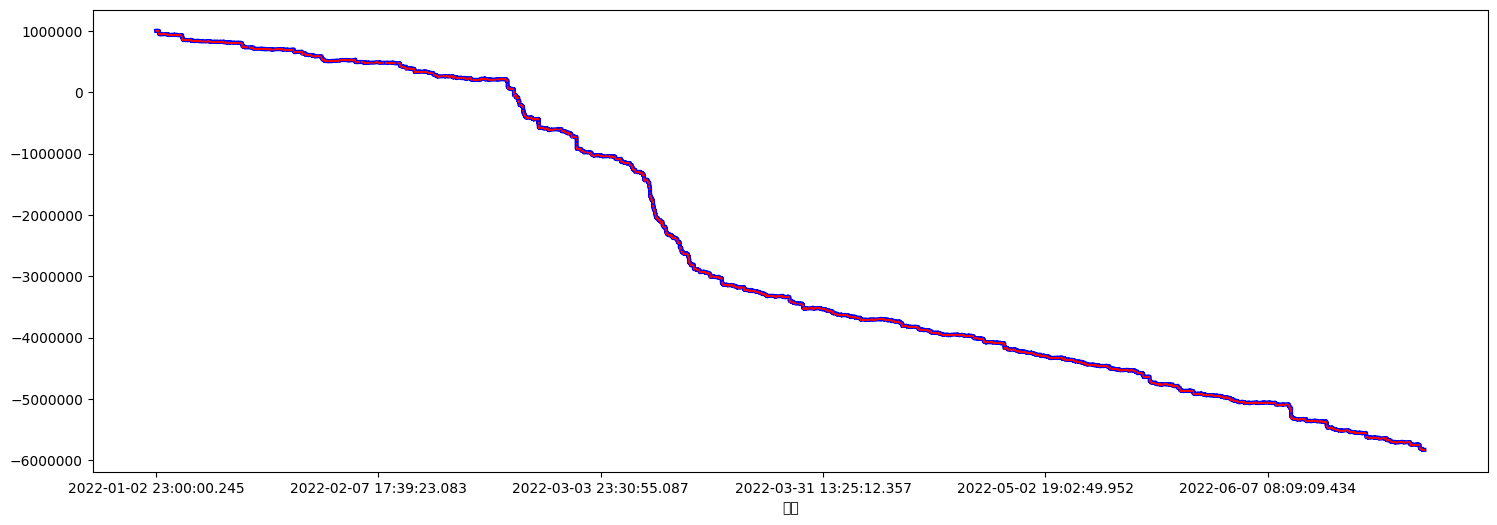

In [ ]:
initial_fund = 1000000

df = df_orders
df = df.reset_index(drop=True)
df = df.set_index('日時')

df['合計損益'] = df['合計損益'] + initial_fund
df['DD'] = df['合計損益'] + df['買含み損益'] + df['売含み損益']

plt.ticklabel_format(style='plain', axis='y')

df['合計損益'].plot(figsize=(18, 6),lw=3,color='blue')
df['DD'].plot(figsize=(18, 6),lw=1,color='red',style=':')


In [ ]:
print('最大DD金額 :' + str(df['DD'].min() - 1000000))
print('最大DD発生日 :' + df['DD'].idxmin() )
print('最終残高 :' + str(df['合計損益'].max()) )


最大DD金額 :-6841525.0
最大DD発生日 :2022-06-30 16:00:10.868
最終残高 :1001573.0
